# Phase 3 Project H1N1 Vaccine Notebook 
## Tim Cleary, Elijah Jarocki, Nick Kennedy

# Business Understanding
In 2009, a virulent h1n1, or swine flu variant began infecting much of the population. It was a virus of concern due it's potential to make people very sick, even more so than tha seasonal flu could. When it became clear that medical efforts were needed, vaccines, both injectable as well as a nasal vaccine containing live, attenuated h1n1 virus were created to minimize risk. However, many of these, especially the more effective (but higher in side-effects) nasal/live vaccine were not widely available across the country. In this report we hope to address the issues concerning vaccination production and vaccination rates.

# Business Problem
There are many obstacles when considering the logistics of vaccine production and dissemination. In 2009 our problem is both understanding vaccine production needs, while also increasing the number of people receiving the vaccine, thereby reducing the global effect of the virus on mortality, hospitalization, and even sick days. Given the still ongoing global pandemic of SARS Covid-19, understanding the reasons why someone may or may not choose a vaccine, and, of course, availablity of vaccines has become crucially important for public health initiatives. In our work below we endeavor to show how to predict vaccination rates with precision, while also identifying how more effort from doctors towards younger demographics could have an outsize impact on those rates.  

# Data Understanding
The Data we used was from the CDC's 2009 National H1N1 Flu Vaccine Survey of nearly 27K respondents. The data is comprised of basic medical, behavioral, and demographic information. 

# Data Cleaning
### 1) importing our libraries

In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, plot_roc_curve, plot_confusion_matrix,\
accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, \
AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
%matplotlib inline

In [2]:
import warnings
# warnings.filter


### loading the data

In [3]:
#Start out by reading our data into a pandas dataframe and then inspecting the layout
df_raw = pd.read_csv('data1.csv')
df_raw.head(2)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

Above we can see both numeric and categorical data, though looking at the df_raw.head we saw that even the numericl data is ordinally  categorical data. Looking here we see a lot of missing values for `health_insurance`, `employment_industry` and `employmnt_occupation`. Lets remove them from our main working dataset and put them on the side for future analysis

In [5]:
df_health = df_raw.copy().dropna(subset=['health_insurance'])
df_health.head(2)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1


Having isolated the observations with health insurance info, we move on to the data we'll inlcude for our analysis


In [6]:
df = df_raw.drop(columns=['employment_industry', 'employment_occupation'])

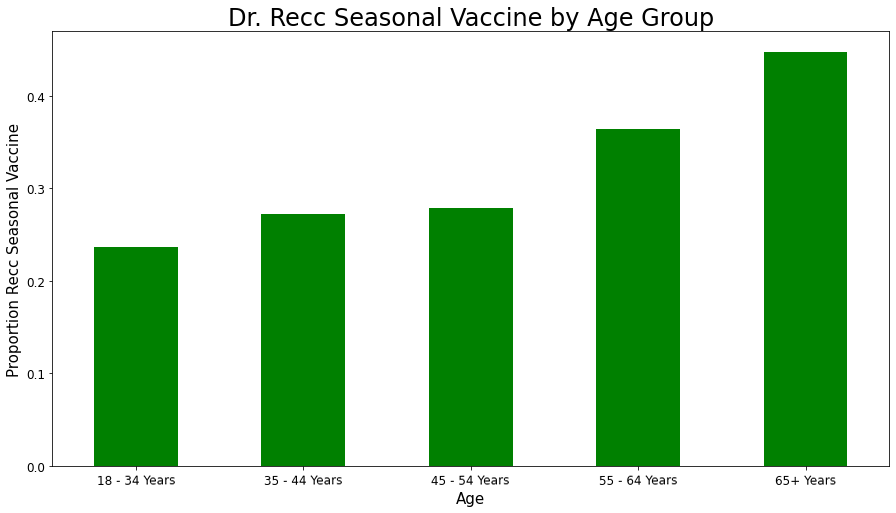

In [7]:
#Looking at seaonsal reccomendations by age
df.groupby('age_group')['doctor_recc_seasonal'].mean().plot.bar(figsize=(15,8), color='g')
plt.title("Dr. Recc Seasonal Vaccine by Age Group", fontsize=24)
plt.xticks(rotation=0.5, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Age", fontsize=15)
plt.ylabel("Proportion Recc Seasonal Vaccine", fontsize=15);

In [8]:
df

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,0,0
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,0,0
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,0,1
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,0,0


In [9]:
df_float = df.loc[:,df_raw.dtypes == 'float64']
df_int = df.loc[:,df_raw.dtypes == 'int64']
df_object = df.loc[:,df_raw.dtypes == 'object']
df_float.shape, df_int.shape, df_object.shape

((26707, 23), (26707, 3), (26707, 10))

In [10]:
df_numeric = pd.concat([df_float, df_int], axis = 1)
df_numeric.shape

(26707, 26)

In [11]:
df_cat_dummied_og = pd.get_dummies(df_object).astype('int64')
df_cat_dummied_og.shape

(26707, 38)

In [12]:
df_encoded = pd.concat([df_numeric, df_cat_dummied_og], axis=1)
df_encoded

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,1
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0,0,0,0,0,0,1,1,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,1,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,1,0,0,0,0,1,0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0,0,0,1,0,0,0,1,0,0
26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0,0,1,0,0,0,0,0,0,1


dropping `health_insurance` from our final dataframe

In [13]:
df_clean = df_encoded.drop('health_insurance', axis =1)
df_clean.dropna(inplace=True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22976 entries, 0 to 26706
Data columns (total 63 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   h1n1_concern                              22976 non-null  float64
 1   h1n1_knowledge                            22976 non-null  float64
 2   behavioral_antiviral_meds                 22976 non-null  float64
 3   behavioral_avoidance                      22976 non-null  float64
 4   behavioral_face_mask                      22976 non-null  float64
 5   behavioral_wash_hands                     22976 non-null  float64
 6   behavioral_large_gatherings               22976 non-null  float64
 7   behavioral_outside_home                   22976 non-null  float64
 8   behavioral_touch_face                     22976 non-null  float64
 9   doctor_recc_h1n1                          22976 non-null  float64
 10  doctor_recc_seasonal              

# Data Modeling Preparation
## Splitting into train and test


In [14]:
X1 = df_clean.drop(columns=['h1n1_vaccine', 'respondent_id'])
y1 = df_clean['h1n1_vaccine']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=99)

## Running the baseline classification model
we run a model below that always chooses the majority class, in this case `0`: respondents who didn't get the vaccine

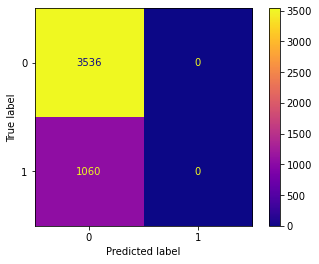

In [15]:
baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(X1_train, y1_train)
plot_confusion_matrix(baseline_model, X1_test, y1_test, cmap='plasma');

In [16]:
print(f'Baseline Accuracy Score: {accuracy_score(y1_test, baseline_model.predict(X1_test))}')
print(f'Baseline Precision Score: {precision_score(y1_test, baseline_model.predict(X1_test))}')

Baseline Accuracy Score: 0.7693646649260226
Baseline Precision Score: 0.0


C:\Users\Timbothy\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Our precision is 0 because our model predicts no positives, but our accuracy for the baseline is 77%

# Feature selection with Random Forest Classifier

### Grid- Searching for the best parameters based on precision
given our business problem we chose to look at precision as our primary evaluation metric because ---TIM HELP!----

Below we search for the best paramaters for our Random Forest Classifer using a GridSearchCV from sci-kit learn. Many attempts were made, and a more thorough process is given here <a href="google.com">google filler NEED TO CHANGE</a>

In [17]:
#choosing paramaters to iterate over given what we learned in our investigations (see link ^)
tuned_parameters = {'min_samples_leaf': [10, 100, 200, 500],
                   'criterion' :  ['gini', 'entropy'],
                    'max_depth' : [None, 5, 7, 10, 20]
                   }
clf = GridSearchCV(RandomForestClassifier(n_estimators=300, random_state=99), 
                    tuned_parameters, cv=3, scoring="precision")
clf.fit(X1_train, y1_train)
clf.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 500}

In [18]:
clf.score(X1_test, y1_test), accuracy_score(y1_test, clf.predict(X1_test))

(0.798941798941799, 0.7939512619669278)

knowing that `n_estimators`, or the number of decision trees in our random forest, can improve rfc models, we increase it now that we no longer have to worry about the computationally heavy grid-searching 

### choosing our final feature selection model

In [19]:
rfc_test1 = RandomForestClassifier(n_estimators=999, criterion='gini', min_samples_leaf=400 , max_depth =7, random_state=99)
rfc_test1.fit(X1_train, y1_train)
precision_score(y1_test, rfc_test1.predict(X1_test))

0.7935779816513762

In [20]:
#looking at the accuracy of our test as well
accuracy_score(y1_test, rfc_test1.predict(X1_test))

0.7972149695387293

In [21]:
rfc_final = RandomForestClassifier(n_estimators=1000, criterion='entropy', min_samples_leaf=500 , max_depth =7, random_state=99)
rfc_final.fit(X1_train, y1_train)
precision_score(y1_test, rfc_final.predict(X1_test))

0.8011363636363636

In [22]:
rfc_test2 = RandomForestClassifier(n_estimators=1000, criterion='entropy', min_samples_leaf=600 , max_depth =6, random_state=99)
rfc_test2.fit(X1_train, y1_train)
precision_score(y1_test, rfc_test2.predict(X1_test))

0.823943661971831

In [23]:
#looking at the accuracy of our test as well
accuracy_score(y1_test, rfc_test1.predict(X1_test))

0.7972149695387293

In [24]:
#Training Cross-Validation, #Testing Cross-validation first test model
cross_val_score(rfc_test1, X1_train, y1_train), cross_val_score(rfc_test1, X1_test, y1_test) 

(array([0.80005441, 0.8054951 , 0.80005441, 0.79815016, 0.80195865]),
 array([0.76956522, 0.76931447, 0.76931447, 0.76931447, 0.76931447]))

In [25]:
#Training Cross-Validation, #Testing Cross-validation final model 
cross_val_score(rfc_final, X1_train, y1_train), cross_val_score(rfc_final, X1_test, y1_test) 

(array([0.79461371, 0.78998912, 0.79189336, 0.7921654 , 0.79406964]),
 array([0.76956522, 0.76931447, 0.76931447, 0.76931447, 0.76931447]))

In [26]:
#Training Cross-Validation, #Testing Cross-validation final model 
cross_val_score(rfc_test2, X1_train, y1_train), cross_val_score(rfc_test2, X1_test, y1_test) 

(array([0.78373232, 0.78210011, 0.78019587, 0.78264418, 0.78618063]),
 array([0.76956522, 0.76931447, 0.76931447, 0.76931447, 0.76931447]))

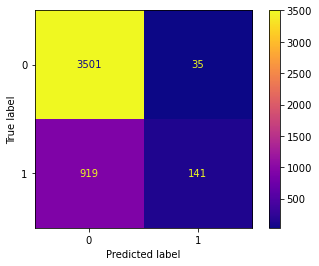

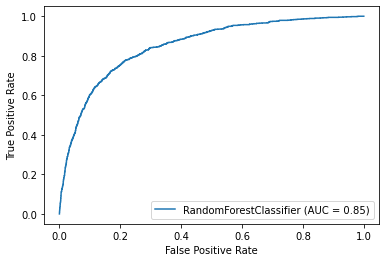

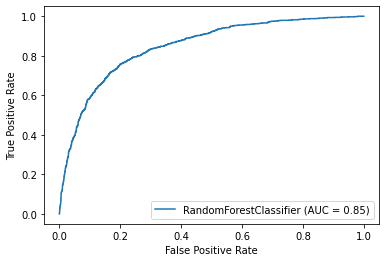

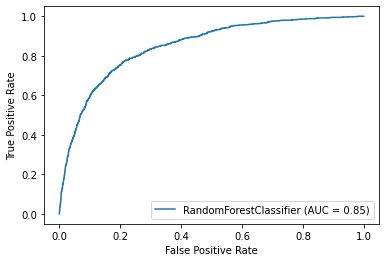

In [27]:
plot_confusion_matrix(rfc_final, X1_test, y1_test, cmap='plasma')
rfc_list = [rfc_test1, rfc_test2, rfc_final]
for x in rfc_list:
    plot_roc_curve(x, X1_test, y1_test) 

### Interpreting and choosing our model for feature selection
as we see all of these models are overfitting on accuracy, we choose Random Forest Classification model with the best precision score, `rfc_final`, as we're only using it for selection for now and know trees have a tendency to overfit by their very nature.

### Combining features identified from Heatmap and RFC

In [28]:
#extracting features from our RFC
feat_import_rfc = {name: score 
                   for name, score 
                       in zip(X1_test.columns, rfc_final.feature_importances_)}
#sorting by feature strength
rfc_feat_sorted = dict(sorted(feat_import_rfc.items(), key=lambda item: item[1], reverse=True))
rfc_feat_sorted

{'seasonal_vaccine': 0.26638716774438304,
 'doctor_recc_h1n1': 0.20010678257848077,
 'opinion_h1n1_risk': 0.15260007002742337,
 'opinion_h1n1_vacc_effective': 0.11333219470634394,
 'opinion_seas_risk': 0.0757703869451454,
 'doctor_recc_seasonal': 0.053352435788768804,
 'opinion_seas_vacc_effective': 0.038186132115727994,
 'health_worker': 0.023010064556950247,
 'h1n1_knowledge': 0.014761165007606554,
 'h1n1_concern': 0.014018470172884098,
 'opinion_h1n1_sick_from_vacc': 0.009840276353731702,
 'chronic_med_condition': 0.0066662582445157215,
 'education_College Graduate': 0.004011201200695646,
 'behavioral_wash_hands': 0.002691920346139515,
 'behavioral_touch_face': 0.0020379320195555526,
 'age_group_65+ Years': 0.0019463219621420628,
 'employment_status_Employed': 0.0018513953879815523,
 'marital_status_Married': 0.001792027244756522,
 'opinion_seas_sick_from_vacc': 0.0017676333031030487,
 'income_poverty_> $75,000': 0.0014723964501597406,
 'marital_status_Not Married': 0.00146567633456

In [29]:
#pulling top few features from our numerical features
top_features = []
for ind in df_numeric.corr()['h1n1_vaccine'].index:
    if abs(df_numeric.corr()['h1n1_vaccine'][ind]) > 0.1:
        top_features.append(ind)

#pulling the top few features from our dummied columns based off correlation
dummied_w_target = pd.concat([df_cat_dummied_og,df['h1n1_vaccine'],df['seasonal_vaccine']], axis=1)
top_features_dummied = []
for ind in dummied_w_target.corr()['h1n1_vaccine'].index:
    if abs(dummied_w_target.corr()['h1n1_vaccine'][ind]) > 0.035:
        top_features_dummied.append(ind)
top_features_dummied.sort()
top_features_dummied

top_features_corr = top_features + top_features_dummied # combining top features from numerical and categorical columns

# Extracting top features from random forest
import itertools
top_30_feat = dict(itertools.islice(rfc_feat_sorted.items(), 30))
top_30_feat_list = [key for key, val in top_30_feat.items()]

# combining top features from random forest and heatmap
top_feat_list = list(set(top_30_feat_list + top_features_corr)) 
top_feat_list.remove('health_insurance')
len(top_feat_list)

35

In [30]:
top_features

['h1n1_concern',
 'h1n1_knowledge',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'h1n1_vaccine',
 'seasonal_vaccine']

now we have a list of features based on feature importance from both correlataion and our the most common splits in our Random Forest's decision trees. 

## Recreating the dataframe using the most impotant features identfied by correlation and RFC
while we lost over 20% of our data initially in cleaning, we apply our new features to our `df_raw` to see if data cleaning using only these selected features can help curb data loss

In [31]:
#### going back to our original dataset
df_feats = df_clean[top_feat_list]
df_feats = df_feats.dropna()

In [32]:
### cleaning our new dataset
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22976 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   employment_status_Employed            22976 non-null  int64  
 1   age_group_65+ Years                   22976 non-null  int64  
 2   income_poverty_> $75,000              22976 non-null  int64  
 3   race_White                            22976 non-null  int64  
 4   opinion_h1n1_sick_from_vacc           22976 non-null  float64
 5   opinion_h1n1_risk                     22976 non-null  float64
 6   h1n1_vaccine                          22976 non-null  int64  
 7   race_Black                            22976 non-null  int64  
 8   opinion_h1n1_vacc_effective           22976 non-null  float64
 9   household_adults                      22976 non-null  float64
 10  marital_status_Married                22976 non-null  int64  
 11  rent_or_own_Own

# Logistic Regression Model creating and tuning
# Model 1
### Running a basic logistic regression

In [33]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22976 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   employment_status_Employed            22976 non-null  int64  
 1   age_group_65+ Years                   22976 non-null  int64  
 2   income_poverty_> $75,000              22976 non-null  int64  
 3   race_White                            22976 non-null  int64  
 4   opinion_h1n1_sick_from_vacc           22976 non-null  float64
 5   opinion_h1n1_risk                     22976 non-null  float64
 6   h1n1_vaccine                          22976 non-null  int64  
 7   race_Black                            22976 non-null  int64  
 8   opinion_h1n1_vacc_effective           22976 non-null  float64
 9   household_adults                      22976 non-null  float64
 10  marital_status_Married                22976 non-null  int64  
 11  rent_or_own_Own

In [34]:
###Running a new train test split
X=df_feats.drop(columns=['h1n1_vaccine'])
y=df_feats['h1n1_vaccine']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=99)

In [35]:
lr_baseline = LogisticRegression(max_iter=500)
lr_baseline.fit(X_train,y_train)
print(f'baseline logistic regression accuracy score: {lr_baseline.score(X_test, y_test)}')
print(f'baseline logistic regression precision score: { precision_score(y_test, lr_baseline.predict(X_test))}')

baseline logistic regression accuracy score: 0.8453002610966057
baseline logistic regression precision score: 0.7130647130647131


clearly we would like to improve on this precision, since our random forest was able to get a much higher precision. Below we'll evaluate how to improve our precision score. we'll check the cross val score, and use stats-models for the summary to eliminate insignificant features. 


In [36]:
cross_val_score(lr_baseline, X_train, y_train, scoring='precision'), cross_val_score(lr_baseline, X_test, y_test, scoring='precision')

(array([0.67921687, 0.72926448, 0.72504092, 0.71749599, 0.68495298]),
 array([0.74657534, 0.67977528, 0.67682927, 0.72916667, 0.71428571]))

just to double check how its fitting on accuracy

In [37]:
cross_val_score(lr_baseline, X_train, y_train), cross_val_score(lr_baseline, X_test, y_test)

(array([0.84031556, 0.85527748, 0.85038085, 0.84929271, 0.83977149]),
 array([0.84782609, 0.83895539, 0.83242655, 0.84113166, 0.84439608]))

In [38]:
lr_baseline_sm =sm.Logit(exog=X_train,endog= y_train).fit()
lr_baseline_sm.summary()

Optimization terminated successfully.
         Current function value: 0.370927
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           h1n1_vaccine   No. Observations:                18380
Model:                          Logit   Df Residuals:                    18346
Method:                           MLE   Df Model:                           33
Date:                Sun, 13 Mar 2022   Pseudo R-squ.:                  0.3034
Time:                        18:20:34   Log-Likelihood:                -6817.6
converged:                       True   LL-Null:                       -9786.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
employment_status_Employed              -0.2867      0.095     -3.013      0.003      -0.473      -0.100
age_group_65+ Years                     -0.0599      0.067     -0.898      0.369      -0.191       0.071
income_poverty_> $75,000                 0.0457      0.056      0.815      0.415      -0.064       0.156
race_White                              -0.6001      0.065     -9.280      0.000      -0.727      -0.473
opinion_h1n1_sick_from_vacc             -0.0269      0.019     -1.391      0.164      -0.065       0.011
opinion_h1n1_risk                        0.4063      0.021     19.384      0.000       0.365       0.447
race_Black                              -0.8406      0.105     -7.975      0.000      -1.047      -0.634
opinion_h1n1_vacc_effective              0.3914      0.027     14.610      0.000       0.339       0.444
household_adults                        -0.1973      0.033     -5.892      0.000      -0.263      -0.132
marital_status_Married                  -2.2819      0.135    -16.941      0.000      -2.546      -2.018
rent_or_own_Own                         -0.0227      0.056     -0.404      0.686      -0.133       0.087
seasonal_vaccine                         2.1167      0.057     37.294      0.000       2.005       2.228
opinion_seas_sick_from_vacc             -0.1108      0.019     -5.786      0.000      -0.148      -0.073
doctor_recc_seasonal                    -1.0270      0.063    -16.250      0.000      -1.151      -0.903
age_group_55 - 64 Years                  0.1225      0.058      2.113      0.035       0.009       0.236
h1n1_concern                            -0.1344      0.029     -4.572      0.000      -0.192      -0.077
behavioral_touch_face                   -0.0921      0.054     -1.718      0.086      -0.197       0.013
child_under_6_months                     0.1409      0.074      1.892      0.058      -0.005       0.287
behavioral_avoidance                    -0.0776      0.055     -1.405      0.160      -0.186       0.031
opinion_seas_risk                       -0.0215      0.021     -1.041      0.298      -0.062       0.019
behavioral_wash_hands                   -0.3014      0.067     -4.483      0.000      -0.433      -0.170
opinion_seas_vacc_effective             -0.2659      0.025    -10.570      0.000      -0.315      -0.217
doctor_recc_h1n1                         2.2923      0.064     35.719      0.000       2.167       2.418
education_College Graduate               0.0801      0.054      1.494      0.135      -0.025       0.185
education_12 Years                       0.0010      0.060      0.017      0.986      -0.117       0.119
employment_status_Not in Labor Force    -0.2069      0.098     -2.104      0.035      -0.400      -0.014
hhs_geo_region_bhuqouqj                 -0.0083      0.069     -0.121      0.903      -0.143       0.126
health_worker                            0.6397      0.065      9.881      0.000       0.51

### interpretation of summary and next steps
above we can see a few of our features have high p-values, while other features seem to have conceptual issues. EX: we know from our EDA that both seasonal and h1n1 vaccines have a large effect on H1N1 vaccination rates, yet only 3 percent of respondents who got an swine flu recc, did not also receive a seaonsal flu vaccine recc, yet both of these coefficients have opposite sines: perhaps an issue of multicolinearity. We do a bit of feature engineering to combine some of our important features in order to see if that affects our model strength. 

In [39]:
#FeatureEngineering doctor_recc_any, a feature that reports if respondent's
# df_refined_1=df_clean.copy()
# df_refined_1.loc[:, df_refined_1['doctor_recc_seasonal']==1]['doctor_recc_any']=1
# df_refined_1.loc[:, df_refined_1['doctor_recc_h1n1']==1]['doctor_recc_any']=1

In [40]:
# df_refined_1['doctor_recc_any'].value_counts() # checking to see if our FE worked

In [41]:
# Feature Engineering over_55
# df_refined_1['over_55'] = 0
# df_refined_1.loc[(df_refined_1['age_group_55 - 64 Years	']==1) | (df_refined_1['age_group_65+ Years'] ==1), 'over_55']=1

In [42]:
#Feature Engineering not_employed_labor_force
# df_refined_1['not_employed_labor_force'] = 0
# df_refined_1.loc[(df_refined_1['employment_status_Not in Labor Force']==1) | (df_refined_1['employment_status_Unemployed'] ==1),'not_employed_labor_force']=1 

In [43]:
#lists of insignificant features that including/excluding engineered features
# insig_feat_w_fe=['opinion_seas_risk', 'hhs_geo_region_bhuqouqj', 'education_College Graduate', 'behavioral_outside_home', 
               #   'chronic_med_condition', 'doctor_recc_seasonal', 'doctor_recc_h1n1', 'employment_status_Unemployed', 
               #   'employment_status_Not in Labor Force' ,'age_group_65+ Years', 'age_group_55 - 64 Years' ] 

# insig_feat = ['opinion_seas_risk', 'hhs_geo_region_bhuqouqj', 'education_College Graduate', 'behavioral_outside_home', 
             # 'chronic_med_condition', 'doctor_recc_any', 'not_employed_labor_force', 'over_55']

## Tuning our model with refined features
1) train test split

In [44]:
X2 = df_feats.drop('h1n1_vaccine', axis=1)
y2= df_feats['h1n1_vaccine']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=99)

In [45]:
lr2 = LogisticRegression(max_iter=500)
lr2.fit(X2_train, y2_train)
lr2.score(X2_test, y2_test)

0.8453002610966057

In [46]:
precision_score(y2_train, lr2.predict(X2_train)), precision_score(y2_test, lr2.predict(X2_test))

(0.7083725305738476, 0.7130647130647131)

In [47]:
lr_sm2 = sm.Logit(endog=y2_train, exog=X2_train).fit()
lr_sm2.summary()

Optimization terminated successfully.
         Current function value: 0.370927
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           h1n1_vaccine   No. Observations:                18380
Model:                          Logit   Df Residuals:                    18346
Method:                           MLE   Df Model:                           33
Date:                Sun, 13 Mar 2022   Pseudo R-squ.:                  0.3034
Time:                        18:20:35   Log-Likelihood:                -6817.6
converged:                       True   LL-Null:                       -9786.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
employment_status_Employed              -0.2867      0.095     -3.013      0.003      -0.473      -0.100
age_group_65+ Years                     -0.0599      0.067     -0.898      0.369      -0.191       0.071
income_poverty_> $75,000                 0.0457      0.056      0.815      0.415      -0.064       0.156
race_White                              -0.6001      0.065     -9.280      0.000      -0.727      -0.473
opinion_h1n1_sick_from_vacc             -0.0269      0.019     -1.391      0.164      -0.065       0.011
opinion_h1n1_risk                        0.4063      0.021     19.384      0.000       0.365       0.447
race_Black                              -0.8406      0.105     -7.975      0.000      -1.047      -0.634
opinion_h1n1_vacc_effective              0.3914      0.027     14.610      0.000       0.339       0.444
household_adults                        -0.1973      0.033     -5.892      0.000      -0.263      -0.132
marital_status_Married                  -2.2819      0.135    -16.941      0.000      -2.546      -2.018
rent_or_own_Own                         -0.0227      0.056     -0.404      0.686      -0.133       0.087
seasonal_vaccine                         2.1167      0.057     37.294      0.000       2.005       2.228
opinion_seas_sick_from_vacc             -0.1108      0.019     -5.786      0.000      -0.148      -0.073
doctor_recc_seasonal                    -1.0270      0.063    -16.250      0.000      -1.151      -0.903
age_group_55 - 64 Years                  0.1225      0.058      2.113      0.035       0.009       0.236
h1n1_concern                            -0.1344      0.029     -4.572      0.000      -0.192      -0.077
behavioral_touch_face                   -0.0921      0.054     -1.718      0.086      -0.197       0.013
child_under_6_months                     0.1409      0.074      1.892      0.058      -0.005       0.287
behavioral_avoidance                    -0.0776      0.055     -1.405      0.160      -0.186       0.031
opinion_seas_risk                       -0.0215      0.021     -1.041      0.298      -0.062       0.019
behavioral_wash_hands                   -0.3014      0.067     -4.483      0.000      -0.433      -0.170
opinion_seas_vacc_effective             -0.2659      0.025    -10.570      0.000      -0.315      -0.217
doctor_recc_h1n1                         2.2923      0.064     35.719      0.000       2.167       2.418
education_College Graduate               0.0801      0.054      1.494      0.135      -0.025       0.185
education_12 Years                       0.0010      0.060      0.017      0.986      -0.117       0.119
employment_status_Not in Labor Force    -0.2069      0.098     -2.104      0.035      -0.400      -0.014
hhs_geo_region_bhuqouqj                 -0.0083      0.069     -0.121      0.903      -0.143       0.126
health_worker                            0.6397      0.065      9.881      0.000       0.51

In [48]:
#choosing best parameters for logistic regression using grid_search
tuned_parameters = {'min_samples_leaf': [10, 100, 200, 500],
                   'criterion' :  ['gini', 'entropy'],
                    'max_depth' : [None, 5, 7, 10, 20]
                   }
clf = GridSearchCV(RandomForestClassifier(n_estimators=300, random_state=99), 
                    tuned_parameters, cv=3, scoring="precision")
clf.fit(X1_train, y1_train)
clf.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 500}

In [49]:
lr = LogisticRegression(max_iter=500)
lr.fit(X1_train, y1_train)

LogisticRegression(max_iter=500)

In [50]:
lr.score(X1_test, y1_test)

0.8429068755439513

In [51]:
precision_score(y1_test, lr.predict(X1_test))

0.706601466992665

In [52]:
tuned_parameters_lr = {'C': [1, 5, 10, 50],
                   'solver' :  ['sag', 'saga', 'lbfgs']
            
                   }
clf = GridSearchCV(LogisticRegression(max_iter=5000,C=5), tuned_parameters_lr, cv=3, scoring="precision")
clf.fit(X2_train, y2_train)

GridSearchCV(cv=3, estimator=LogisticRegression(C=5, max_iter=5000),
             param_grid={'C': [1, 5, 10, 50],
                         'solver': ['sag', 'saga', 'lbfgs']},
             scoring='precision')

In [53]:
clf.best_params_

{'C': 50, 'solver': 'sag'}

In [54]:
lr_try = LogisticRegression(C=10, solver='lbfgs', max_iter=1000)
lr_try.fit(X1_train, y1_train)

LogisticRegression(C=10, max_iter=1000)

In [55]:
precision_score(y1_test, lr_try.predict(X1_test))

0.7062423500611995

In [56]:
clf.score(X2_test, y2_test)

0.7121951219512195

# Conclusion: 
### Through our findings we've discovered that a relationship with/ reccomendation from one's MD is critical for vaccine-willingness in patients. We also learned that these Dr. Reccomendations are given at a much higher rate to older generations. In the world-changing global pandemic of SARS COVID-19, the world saw that younger people are much more amenaable to receiving vaccines. Thus we propose measures to increase Dr. reccomendations to younger demographics. For further research we intend to look at the impacts of
- having health insurance
- having had the flu in the past